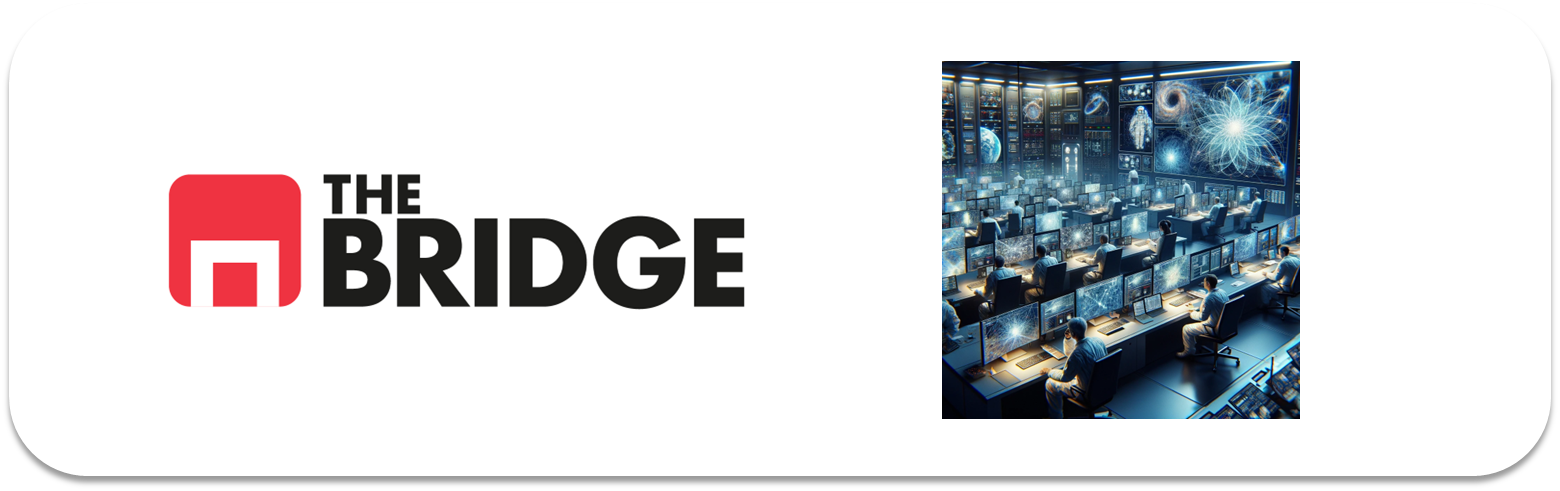

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [29]:
import os
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns


### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



In [16]:

# Tamaño de imagen deseado
IMG_SIZE = (32, 32)

# Función para cargar imágenes y etiquetas desde un directorio
def load_images_from_directory(directory):
    images = []
    labels = []
    
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        
        try:
            # Cargar la imagen y convertirla a RGB
            img = Image.open(filepath).convert('RGB')
            img = img.resize(IMG_SIZE)  # Redimensionar a 32x32
            img_array = np.array(img) / 255.0  # Normalizar entre 0 y 1
            
            # Determinar la clase a partir del nombre del archivo
            label = 1 if 'dog' in filename.lower() else 0  # 1 = Perro, 0 = Gato
            
            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f'Error al procesar {filename}: {e}')
    
    return np.array(images), np.array(labels)


In [17]:
# Directorios de entrenamiento
train_dirs = ['./data/github_train_0', './data/github_train_1', 
              './data/github_train_2', './data/github_train_3']

# Inicializar listas
X_train_list, y_train_list = [], []

# Cargar imágenes de cada directorio
for train_dir in train_dirs:
    X, y = load_images_from_directory(train_dir)
    X_train_list.append(X)
    y_train_list.append(y)

# Concatenar todas las imágenes y etiquetas en arrays únicos
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

# Mostrar dimensiones
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')


X_train shape: (4000, 32, 32, 3)
y_train shape: (4000,)


In [18]:
# Directorio de test
test_dir = './data/github_test'

# Cargar imágenes de test
X_test, y_test = load_images_from_directory(test_dir)

# Mostrar dimensiones
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


X_test shape: (1000, 32, 32, 3)
y_test shape: (1000,)


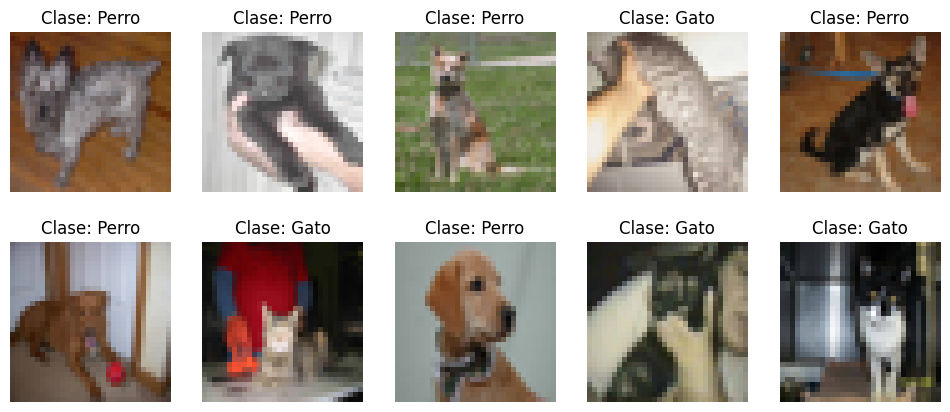

In [19]:
# Función para visualizar algunas imágenes del dataset
def plot_sample_images(X, y, num_samples=10):
    fig, axes = plt.subplots(2, num_samples // 2, figsize=(12, 5))
    axes = axes.ravel()

    for i in range(num_samples):
        idx = np.random.randint(0, len(X))  # Seleccionar una imagen aleatoria
        axes[i].imshow(X[idx])
        axes[i].set_title(f'Clase: {"Perro" if y[idx] == 1 else "Gato"}')
        axes[i].axis('off')

    plt.show()

# Mostrar imágenes de entrenamiento
plot_sample_images(X_train, y_train)


In [20]:
# Definir el modelo CNN
model = keras.Sequential([
    # Primera capa convolucional + MaxPooling
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),

    # Segunda capa convolucional + MaxPooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Aplanar la salida de las convoluciones
    layers.Flatten(),
    
    # Capa densa totalmente conectada
    layers.Dense(128, activation='relu'),

    # Capa de salida con softmax (para clasificación binaria usamos una neurona con sigmoid)
    layers.Dense(1, activation='sigmoid')
])

# Mostrar la estructura del modelo
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,561 (1.20 MB)

 Trainable params: 314,561 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [23]:
# Definir el callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [24]:
# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=50,  # Número máximo de épocas
    batch_size=32,
    validation_split=0.2,  # 20% de los datos se usan para validación
    callbacks=[early_stopping],  # Aplicar EarlyStopping
    verbose=1
)


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6105 - loss: 0.6776 - val_accuracy: 0.0550 - val_loss: 0.9683
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6585 - loss: 0.6367 - val_accuracy: 0.5962 - val_loss: 0.6628
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6888 - loss: 0.5850 - val_accuracy: 0.5188 - val_loss: 0.7533
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7289 - loss: 0.5335 - val_accuracy: 0.4500 - val_loss: 0.8738
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7559 - loss: 0.5093 - val_accuracy: 0.6425 - val_loss: 0.6345
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7795 - loss: 0.4773 - val_accuracy: 0.5288 - val_loss: 0.8150
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7990 - loss: 0.4360 - val_accuracy: 0.7550 - val_loss: 0.5237
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8179 - loss: 0.4118 - val_accuracy: 0

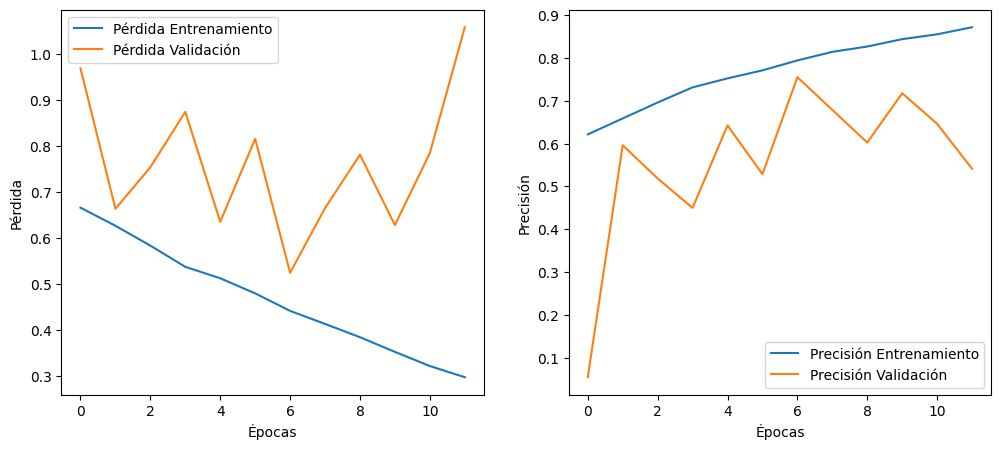

In [25]:
# Graficar el historial de entrenamiento
import matplotlib.pyplot as plt

# Extraer datos del historial
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

# Graficar la pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Pérdida Entrenamiento')
plt.plot(epochs, val_loss, label='Pérdida Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Graficar la precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Precisión Entrenamiento')
plt.plot(epochs, val_accuracy, label='Precisión Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()


In [26]:
# Evaluar el modelo en test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Mostrar resultados
print(f'Pérdida en test: {test_loss:.4f}')
print(f'Precisión en test: {test_accuracy:.4f}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7398 - loss: 0.5163 
Pérdida en test: 0.5231
Precisión en test: 0.7590


In [28]:
# Hacer predicciones en el conjunto de test
y_pred_probs = model.predict(X_test)  # Probabilidades de clase
y_pred = (y_pred_probs > 0.5).astype(int)  # Convertir a 0 o 1

# Generar el reporte de clasificación
report = classification_report(y_test, y_pred, target_names=['Gato', 'Perro'])
print(report)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

        Gato       0.77      0.74      0.75       500
       Perro       0.75      0.78      0.76       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



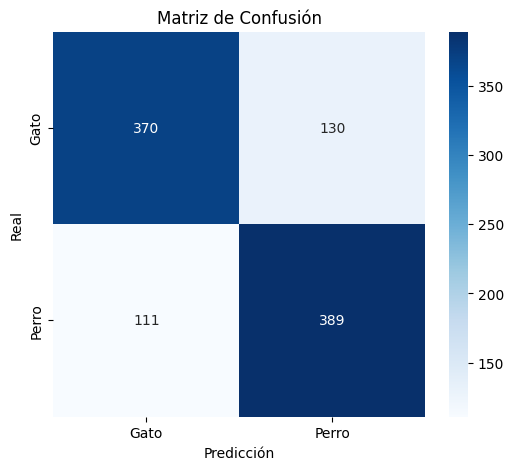

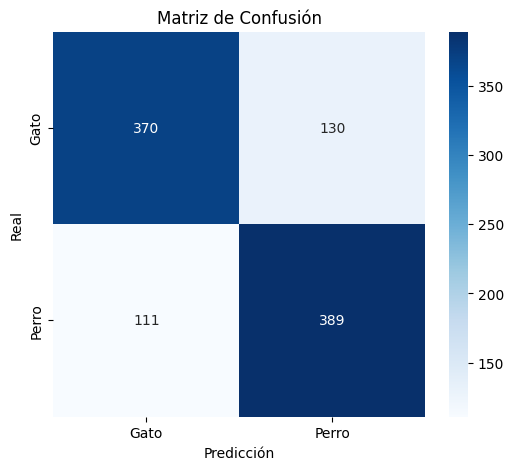

In [30]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gato', 'Perro'], yticklabels=['Gato', 'Perro'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gato', 'Perro'], yticklabels=['Gato', 'Perro'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


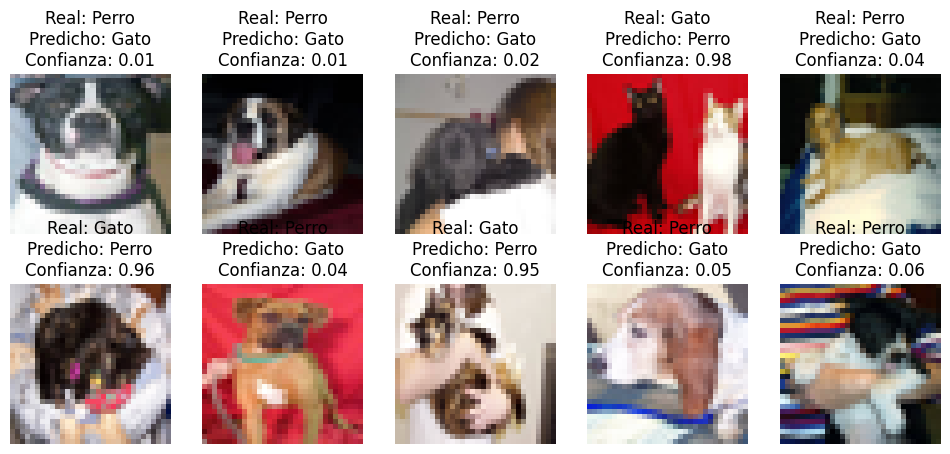

In [31]:
# Obtener las probabilidades de predicción
y_pred_probs = model.predict(X_test)  # Probabilidad de ser perro
y_pred = (y_pred_probs > 0.5).astype(int)  # Convertir a 0 (gato) o 1 (perro)

# Identificar imágenes mal clasificadas
misclassified_idx = np.where(y_pred.ravel() != y_test)[0]  # Índices de errores

# Ordenar por confianza (mayor diferencia con 0.5)
confidence_scores = np.abs(y_pred_probs[misclassified_idx] - 0.5)
sorted_indices = misclassified_idx[np.argsort(-confidence_scores.ravel())]  # Orden descendente

# Seleccionar el 10% más confiado de los errores
num_select = int(0.1 * len(y_test))  # 10% del conjunto de test
hardest_misclassified = sorted_indices[:num_select]

# Mostrar algunas de estas imágenes mal clasificadas
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    idx = hardest_misclassified[i]
    axes[i].imshow(X_test[idx])
    true_label = 'Perro' if y_test[idx] == 1 else 'Gato'
    pred_label = 'Perro' if y_pred[idx] == 1 else 'Gato'
    confidence = y_pred_probs[idx][0]
    axes[i].set_title(f'Real: {true_label}\nPredicho: {pred_label}\nConfianza: {confidence:.2f}')
    axes[i].axis('off')

plt.show()
